This notebook contains all the code used to model the ball balancer system
(HW2) and to simulate it numerically (HW3). To skip to the results, click
[here](#model) to see the final model of the system and [here](#plots)
to see the plots of the simulation results. Also, the notebook file can be
downloaded from bitbucket [here](https://bitbucket.org/jmclau05/me305lab/src/master/jupyter/termproject.ipynb).

# Imports/Setup

In [43]:
import sympy as sp
import numpy as np
from sympy.physics.mechanics import dynamicsymbols, vlatex
import sympy.physics.vector as vec
from scipy import integrate
import matplotlib.pyplot as plt
from IPython.display import SVG
# Print derivatives using dot notation
vec.init_vprinting()

# Variables

## Parameter Variables

### Symbols

Create a sympy `Symbol` for each of the parameters used in the model.

In [44]:
# Radius of Lever Arm
r_m = sp.Symbol('r_m')
# Length of Push Rod
l_r = sp.Symbol('l_r')
# Radius of Ball
r_B = sp.Symbol('r_B')
# Vertical Distance from U-Joint to CG of Platform
r_G = sp.Symbol('r_G')
# Horizontal Distance from U-Joint to Push-Rod Pivot
l_P = sp.Symbol('l_P')
# Vertical Distance from U-Joint to Push-Rod Pivot
r_P = sp.Symbol('r_P')
# Vertical Distance from U-Joint to Platform Surface
r_C = sp.Symbol('r_C')
# Mass of Ball
m_B = sp.Symbol('m_B')
# Mass of Platform
m_P = sp.Symbol('m_P')
# Moment of Inertia of Platform (About Horizontal Axis through CG)
I_P = sp.Symbol('I_P')
# Viscous Friction at U-Joint
b = sp.Symbol('b')

# Gravity
g = sp.Symbol('g')

### Values (in SI units)

Place the numerical parameters in a dictionary mapping the previously defined
symbols to numbers representing their values in SI units. This will make it
easy to substitute them all at once when it is time to do the numerical
simulation later. SI units make sure that no conversion factors are needed.

In [45]:
param_mm = {'r_m': 60,
            'l_r': 50,
            'r_B': 10.5,
            'r_G': 42,
            'l_P': 110,
            'r_P': 32.5,
            'r_C': 50}

sym_to_num = {}
for name in param_mm:
    sym_to_num[sp.Symbol(name)] = param_mm[name] / 1000 # convert to m
    
sym_to_num['m_B'] = 0.030       # kg
sym_to_num['m_P'] = 0.400       # kg
sym_to_num['I_P'] = 1.88e-3     # kg-m^2
sym_to_num['b'] = 10 / 1000     # N-m-s/rad
sym_to_num['g'] = 9.81          # m/s^2

## Motion Variables

Set up the ball position, $x$, and platform angle, $\theta_y$, as
`dynamicsymbols` since this will allow them to be printed using the dot
notation for derivatives. Give derivatives of $x$ and $\theta_y$ names for 
convenience. Set up the remaining variables of time and motor torque as normal 
symbols.

In [46]:
# Time
t = sp.Symbol('t')
# Platform angle and derivatives
thy = dynamicsymbols('theta_y')
thyd = sp.diff(thy, t)
thydd = sp.diff(thy, t, 2)
# Ball position and derivatives
x = dynamicsymbols('x')
xd = sp.diff(x, t)
xdd = sp.diff(x, t, 2)
# Motor torque
T_x = sp.Symbol('T_x')


# Kinematics

## Linkage
The platform is linked to the motor by the motor arm AD and pushrod PQ.

Assumptions:
1.  The pushrod remains vertical.
2.  The mechanism remains close to the pictured reference position. This
    means we can use the small angle approximation everywhere.

By assumption 1, the vertical displacement from the reference position is
equal at points P and Q. Express this displacement at each point, and
set these expressions equal to find the kinematics of the linkage:
$$r_m\sin{\phi_x} = -l_P\sin{\theta_y}$$
For a small angle:
$$r_m\phi_x = -l_P\theta_y$$
$$\theta_y = -\frac{r_m}{l_P}\phi_x$$
Take derivatives with respect to time to get the angular velocity and
angular acceleration relationships as the same ratio:
$$\dot{\theta_y} = -\frac{r_m}{l_P}\dot{\phi_x}$$
$$\ddot{\theta_y} = -\frac{r_m}{l_P}\ddot{\phi_x}$$

## Ball and Plate


Using Sympy's vector math capabilities, set up a global (inertial) 
reference frame, N.

In [47]:
N = vec.ReferenceFrame('N')

Next, make a rotating reference frame aligned with N on each of their y-axes
and attached to the platform, P.

In [48]:
P = N.orientnew('P', 'Axis', [thy, N.y])

Define the platform pivot point O and fix it in the global frame.
This point is also the origin for both N and P. Refer to the diagram below.

In [49]:
O = vec.Point('O')
O.set_vel(N, 0)

Show a diagram for the kinematics of the ball and plate together.

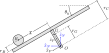

In [50]:
SVG(filename='./kinematics.svg')

Next, define point B, the center of mass of the ball,  in the platform frame P.
Use this equation for the displacement vector of point B from O:
$$\mathbf{\vec{r}}_{B/O} = x\hat{x}_P + (r_B + r_B) \hat{z}_P$$
Also define the velocity of B using the derivative of this vector.

In [51]:
r_BO = x * P.x + (r_C + r_B) * P.z
B = O.locatenew('B', r_BO)
B.set_vel(P, r_BO.dt(P))

Define point G, the center of mass of the platform, in the platform frame P.
Use this equation for the displacement vector of point B from O:
$$\mathbf{\vec{r}}_{G/O} = (r_B + r_B) \hat{z}_P$$

In [52]:
r_GO = r_G * P.z
G = O.locatenew('G', r_GO)

Use Sympy's `a1pt_theory` and `a2pt_theory` kinematics methods to find the
accelerations of the ball and platform at their centers of mass in the global
frame N. These implement the 5-term acceleration equation to translate the
acceleration in the rotating reference frame to the global frame.

In [53]:
a_B = B.a1pt_theory(O, N, P)
a_G = G.a2pt_theory(O, N, P)

Since the ball rolls without slip, its angular acceleration is:
$$\alpha_B = \ddot{\theta}_y + \frac{\ddot{x}}{r_B}$$

In [54]:
alpha_B = (thydd + xdd/r_B) * P.y

The platform's angular acceleration is:
$$\alpha_P = \ddot{\theta}_y$$

In [55]:
alpha_P = thydd * P.y

# Kinetics

## Linkage

Use the method of virtual work, to find the relationship between the
motor torque and the effective moment on the platform. 
Assumptions:
1.  The motor and pushrod have negligible inertia and mass. 
2.  There is no friction or other loss of energy

By these assumptions, no energy can be stored, and all the work done by the
motor will go to the platform.
$$dE = dW_{IN} - dW_{OUT} = 0$$
$$dW_{IN} = dW_{OUT}$$
On both sides of the linkage, the work is done by a torque over a small 
anglular displacement.
$$T_x d\phi_x = M_y d\theta_y$$
$$M_y = T_X \frac{d\phi_x}{d\theta_y}$$
Substitute for the time derivative of the angle.
$$M_y = T_X \frac{\frac{d\phi_x}{dt}} {\frac{d\theta_y}{dt}}$$
$$M_y = T_x \frac{\dot{\phi}_x}{\dot{\theta}_y}$$
Substitute the kinematic relationship between the angular velocity found
earlier.
$$M_y = -\frac{l_P}{r_m} T_x$$


In [56]:
M_y = -l_P/r_m * T_x * P.y

## Ball and Platform

Considering the system of the ball and plate, sum moments about the pivot
point of the platform, O. See the free-body diagram and moment equation below.

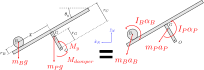

In [57]:
SVG(filename='./FBDKDplate.svg')

$$
\Sigma M_O \mathrm{:}
M_y \hat{y}_N +
M_{damper} +
\vec{\mathbf{r}}_{B/O} \times (-m_B g \hat{z}_N) +
\vec{\mathbf{r}}_{G/O} \times (-m_P g \hat{z}_N) =
I_B \vec{\alpha}_B +
I_P \vec{\alpha}_P +
\vec{\mathbf{r}}_{B/O} \times m_B \vec{\mathbf{a}}_B +
\vec{\mathbf{r}}_{G/O} \times m_P \vec{\mathbf{a}}_P
$$

Express the weights of the ball and platform as vectors in the global frame.

In [58]:
weight_ball = m_B * g * -N.z
weight_platform = m_P * g * -N.z

The moment of inertia of the ball about its center of mass, $I_B$, is
$$I_B=\frac{2}{5}m_Br_B^2$$

In [59]:
I_B = 2/5 * m_B * r_B ** 2

and the moment on the plate due to damping in the U-joint is
$$M_{damper} = -b \dot{\theta}_y$$

In [60]:
M_damper = -b * thyd * P.y

This equation can be evaluated in sympy, to get a differential equation in
terms of $x$ and $\theta_y$ and their derivatives, and the system parameters.

In [61]:
FBD_both = vec.cross(r_BO, weight_ball) + vec.cross(r_GO, weight_platform) \
    + M_y + M_damper
KD_both = vec.cross(r_BO, m_B * a_B) + vec.cross(r_GO, m_P * a_G) \
    + I_P * alpha_P + I_B * alpha_B

These expressions are still in vector form, but only have a y-component. Take
the dot product of them with the unit vector in the y-direction to make them
into scalars. Also expand the terms of the equation.

In [62]:
FBD_both = FBD_both.dot(N.y).expand()
KD_both = KD_both.dot(N.y).expand()

Apply the small angle approximation $\sin{\theta_y} \approx \theta_y$,
$\cos{\theta_y} \approx 1$. Now the equation for the kinetics of the ball
can be displayed.

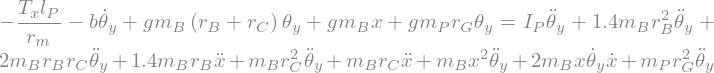

In [63]:
FBD_both = FBD_both.subs({sp.sin(thy): thy, sp.cos(thy): 1})
sp.Eq(FBD_both.collect([m_B * g * thy]), KD_both)

Next, consider the ball alone. Sum moments about the contact point of the ball 
on the surface of the platform, C.

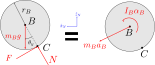

In [64]:
SVG(filename='./FBDKDball.svg')

$$
\Sigma M_C\colon
\vec{\mathbf{r}}_{B/C} \times (-m_B g \hat{z}_N) =
I_B \vec{\alpha}_B +
\vec{\mathbf{r}}_{B/C} \times m_B \vec{\mathbf{a}}_B
$$

Evaluate this equation in sympy and perform the same simplifications as above.

In [23]:
FBD_ball = vec.cross(r_B * P.z, weight_ball)
KD_ball = vec.cross(r_B * P.z, m_B * a_B) + I_B * alpha_B
KD_ball = KD_ball.dot(P.y).expand()
FBD_ball = FBD_ball.dot(P.y).subs(sp.sin(thy), thy)
sp.Eq(FBD_ball, KD_ball)

<a id="model"></a>
In matrix form, these two equations are:
$$M \ddot{\mathbf{q}} = \mathbf{f}$$
$$
\left[\begin{matrix}- \frac{I_{B}}{r_{B}} - m_{B} r_{B} - m_{B} r_{C} & - I_{B} - I_{P} - m_{B} r_{B}^{2} - 2 m_{B} r_{B} r_{C} - m_{B} r_{C}^{2} - m_{B} x^{2} - m_{P} r_{G}^{2}\\- \frac{I_{B}}{r_{B}} - m_{B} r_{B} & - I_{B} - m_{B} r_{B}^{2} - m_{B} r_{B} r_{C}\end{matrix}\right]
\left[\begin{matrix}\ddot{x}\\\ddot{\theta}_{y}\end{matrix}\right]      =
\left[\begin{matrix}\frac{T_{x} l_{P}}{r_{m}} + b \dot{\theta}_{y} - g m_{B} r_{B} \theta_{y} - g m_{B} r_{C} \theta_{y} - g m_{B} x - g m_{P} r_{G} \theta_{y} + 2 m_{B} x \dot{\theta}_{y} \dot{x}\\- g m_{B} r_{B} \theta_{y} - m_{B} r_{B} x \dot{\theta}_{y}^{2}\end{matrix}\right]
$$
This completes the model, which will be used next to simulate the motion of
the system.

# System Simulation

## Linearization and Conversion to State Space Form

Convert the previous equations of motion into a state space form, so the system
can be simulated. The desired form is
$\dot{\mathbf{x}} = A \mathbf{x} + B \mathbf{u}$ where
$\mathbf{x} = \left[\begin{matrix}x\\\theta_y\\\dot{x}\\\dot{\theta}_{y}\end{matrix}\right]$ and
$\dot{\mathbf{x}} = \left[\begin{matrix}\dot{x}\\\dot{\theta}_{y}\\\ddot{x}\\\ddot{\theta}_{y}\end{matrix}\right]$

First, collect the elements of the left matrix $\mathbf{M}$
and the right vector $\mathbf{f}$ from above.

In [24]:
M11 = -KD_both.coeff(xdd)
M12 = -KD_both.coeff(thydd)
M21 = -KD_ball.coeff(xdd)
M22 = -KD_ball.coeff(thydd)
f1 = -FBD_both + (KD_both + M11 * xdd + M12 * thydd).simplify()
f2 = -FBD_ball + (KD_ball + M21 * xdd + M22 * thydd).simplify()

Assemble these elements into sympy matrices, and calculate the unknown vector 
$\ddot{\mathbf{q}}$.
$$\ddot{\mathbf{q}} = M^{-1} \mathbf{f}$$

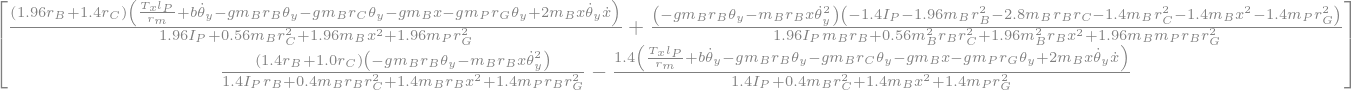

In [25]:
M = sp.Matrix([[M11, M12], [M21, M22]])
f = sp.Matrix([f1, f2])
qdd = M ** -1 * f
qdd

Set up the state vector and its derivative using the $\ddot{\mathbf{q}}$
vector just found.
$$\mathbf{x} = \left[ \begin{matrix} \mathbf{q} \\ \dot{\mathbf{q}} \end{matrix} \right], \quad
\dot{\mathbf{x}} = \left[ \begin{matrix} \dot{\mathbf{q}} \\ \ddot{\mathbf{q}} \end{matrix} \right]$$

In [26]:
state = sp.Matrix([x, thy, xd, thyd])
stated = sp.Matrix([sp.Matrix([xd, thyd]), qdd])

The equation for $\dot{\mathbf{x}}$ contains nonlinear terms such as
$2 m_B x \dot{\theta_y} \dot{x}$ and
$-m_B r_B x \dot{\theta_y}^2$.
To represent the system in state-space, it must be linearized. This is done by
a Jacobian linearization. First, find the Jacobian matrix of the derivative of
the state vector $\dot{\mathbf{x}}$, with respect to the state vector
$\mathbf{x}$.
$$\mathbf{J}_\mathbf{x} = \frac{\partial \dot{\mathbf{x}}(\mathbf{x},\mathbf{u})}{\partial \mathbf{x}}$$

In [27]:
J_x = stated.jacobian(state)

Also find the Jacobian matrix of $\dot{\mathbf{x}}$ with respect to the input
$\mathbf{u} = T_x$. 
$$\mathbf{J}_\mathbf{u} = \frac{\partial \dot{\mathbf{x}}(\mathbf{x},\mathbf{u})}{\partial \mathbf{u}}$$

In [28]:
J_u = stated.jacobian([T_x])

The operating point about which we will linearize is
the state where the ball is at rest in the center of a level plate, and there 
is no torque input from the motor ($\mathbf{x}=0, \mathbf{u}=T_x=0$).
This is a steady state, and the system will not be able
to deviate too far from it while the ball moves on its area.

In [29]:
operating_point = {x: 0, thy: 0, xd: 0, thyd: 0, T_x: 0}


$A$ is $\mathbf{J_x}$ evaluated at this operating point:
$$ A = \mathbf{J_x}|_{\mathbf{x}=0,\mathbf{u}=0}$$

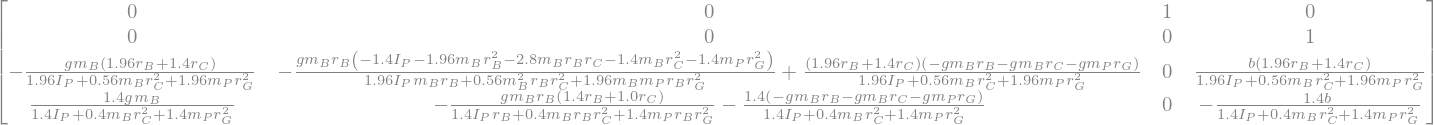

In [30]:
A = J_x.subs(operating_point)
A

And $B$ is $\mathbf{J_u}$ evaluated at the same operating point:
$$ B = \mathbf{J_u}|_{\mathbf{x}=0,\mathbf{u}=0}$$

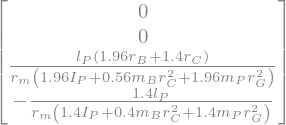

In [31]:
B = J_u.subs(operating_point)
B

This completes the state-space model. Now, it will be simulated numerically.

## Numerical Simulation (Integration)

The parameters given will be substituted and the matrix will be converted to a
numpy array. The parameter values are in SI units (MKS) so no conversion 
factors are necessary.

In [32]:
A_num = np.array(A.subs(sym_to_num).tolist(), dtype=np.float64)
A_num

array([[  0.        ,   0.        ,   1.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   1.        ],
       [ -5.21699855,   4.01109512,   0.        ,   0.17726804],
       [112.88714026,  64.82947198,   0.        ,  -3.83578458]])

In [33]:
B_num = np.array(B.subs(sym_to_num).tolist(), dtype=np.float64)
B_num

array([[   0.        ],
       [   0.        ],
       [  32.49914151],
       [-703.22717343]])

Define a function that calculates the derivative of the state given the
state and input. This uses matrix multiplication from numpy.

In [34]:
def calc_state_d(current_state, torque):
    return A_num @ current_state + B_num @ torque

For open loop, the torque input is always 0.

In [35]:
def open_loop(t, current_state):
    return calc_state_d(current_state, np.array([0]))

The controller for the system will use full state feedback, 
$\mathbf{u} = T_x = - K \mathbf{x}$. 

The gains are shown in the matrix form of this
equation,
$$
T_x = - \left[ \begin{matrix} -0.3 & -0.2 & -0.05 & -0.02 \end{matrix} \right]
\left[ \begin{matrix} x \\ \theta_y \\ \dot{x} \\ \dot{\theta}_y \end{matrix} \right]
$$
These gains are for a nearly fuel-optimal controller. The ball may oscillate
significantly but it will remain stable on the plate.

In [36]:
def closed_loop(t, current_state):
    K = np.array([[-7.3, -2.36, -2, -0.19]])
    torque = -K @ current_state
    return calc_state_d(current_state, torque)

There are two initial conditions we wish to consider.
1.  The ball is at rest in the center of the platform (directly above the
    U-joint) and the platform is level and at rest.
2.  The ball is at rest 5cm away from the center of the platform, which is
    level and at rest.

Form the state vectors for these initial conditions.

In [37]:
ball_at_rest = np.array([0, 0, 0, 0])
ball_offset = np.array([0.05, 0, 0, 0])

Define a function to plot all of the state variables from the results of the
simulation in a window with 4 subplots.

In [38]:
def plot_state(result, title):
    plt.figure(figsize=(10, 6))
    plt.suptitle(title)
    ylabels = ["Ball Position, $x$ [m]", "Platform angle $\\theta_y$ [rad]",
        "Ball Velocity, $\\dot{x}$ [m/s]",
        "Platform Angular Velocity, $\\dot{\\theta}_y$ [rad/s]"]
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(result.t, result.y[i, :])
        plt.xlabel("Time, $t$ [s]")
        plt.ylabel(ylabels[i])
    plt.tight_layout()

<a id="plots"></a>
Now the simulation can be done by integrating the state space equation. First,
run it in open loop with the ball in the first initial condition.

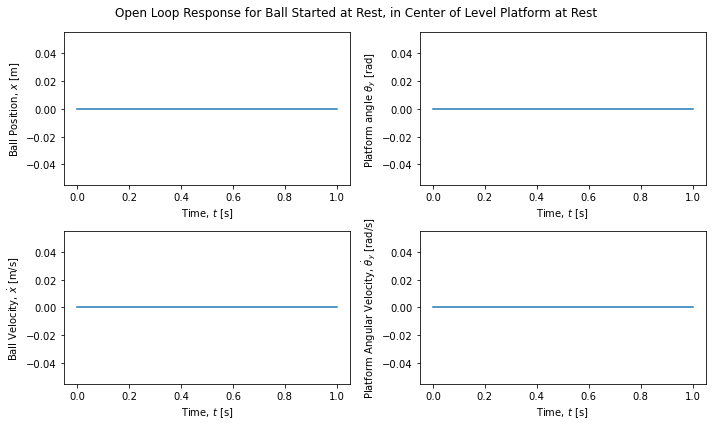

In [39]:
OL_center = integrate.solve_ivp(open_loop, [0, 1], ball_at_rest)
plot_state(OL_center, "Open Loop Response for Ball Started at Rest, in Center "
    "of Level Platform at Rest")

As expected, the ball and platform will stay still according to the model. In
this condition the forces are balanced on the ball and platform. In the real
world, the ball will likely move slightly, as the motor balances it. But since
no external disturbances are in the model, we expect to see no movement.

Next, run the open-loop simulation with the ball starting from the condition
with the ball offset.

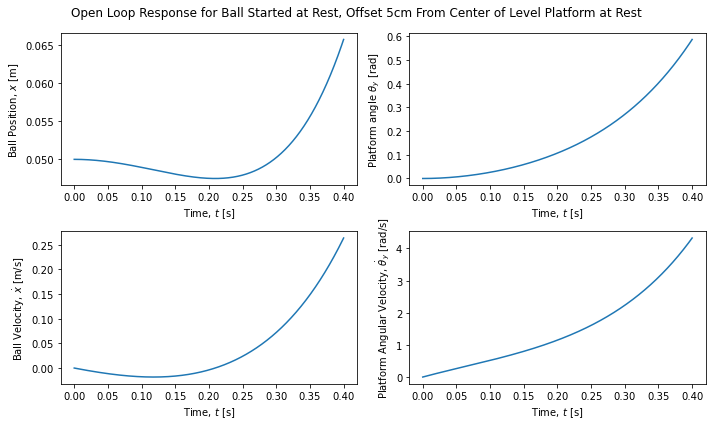

In [40]:
OL_off = integrate.solve_ivp(open_loop, [0, 0.4], ball_offset, 
    t_eval=np.linspace(0, 0.4, 1000))
plot_state(OL_off, "Open Loop Response for Ball Started at Rest, Offset 5cm "
    "From Center of Level Platform at Rest")

These results make sense for the starting conditions and open loop condition.
It is expected that the ball will not stay on the plate, because its weight
will tilt the plate, and the ball will roll off. This happens in the same
direction that the ball was displaced from the center of the plate, $x > 0$
in this case. This behavior can be seen in the position of the ball, which
ends up increasing towards the end of the run, and in the angle of the 
platform, which increases as well as the ball continually pushes it down.
One unexpected phenomenon is that the ball's position initially goes towards
the center of the plate at first. However, this is explained by the fact that
the platform moves relative to the ball as it tilts down under its own weight
after being tipped by the weight of the ball. This causes the ball's position
to move closer to the center of the plate before gravity causes the ball to
roll down the plate.

The next simulation to run is the one that will start with the ball in the
same offset position, but in closed loop with the motor attempting to balance
the ball.

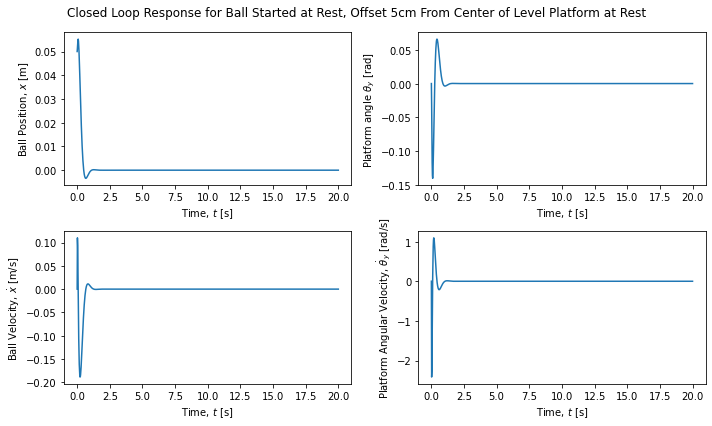

In [41]:
CL_offset = integrate.solve_ivp(closed_loop, [0, 20], ball_offset, t_eval=np.linspace(0, 20, 1000))
plot_state(CL_offset, "Closed Loop Response for Ball Started at Rest, Offset "
    "5cm From Center of Level Platform at Rest")

These results are expected. The controller is able to succesfully balance the 
ball and get it back to the center of the plate. There is oscillation in the
position and velocity of the ball and the platform which decays slowly to 0. 
The phase of the plaform position is opposite of the ball position because it 
is attempting to balance the ball by causing it to roll back towards center.

# Utilities

This prints some $\LaTeX$ that can be used to show the equations of motion in
matrix form.

In [42]:
print('$$')
print(vlatex(M))
print(vlatex(qdd), '=')
print(vlatex(f))
print('$$')

$$
\left[\begin{matrix}- 1.4 m_{B} r_{B} - m_{B} r_{C} & - I_{P} - 1.4 m_{B} r_{B}^{2} - 2 m_{B} r_{B} r_{C} - m_{B} r_{C}^{2} - m_{B} x^{2} - m_{P} r_{G}^{2}\\- 1.4 m_{B} r_{B} & - 1.4 m_{B} r_{B}^{2} - m_{B} r_{B} r_{C}\end{matrix}\right]
\left[\begin{matrix}\frac{\left(1.96 r_{B} + 1.4 r_{C}\right) \left(\frac{T_{x} l_{P}}{r_{m}} + b \dot{\theta}_{y} - g m_{B} r_{B} \theta_{y} - g m_{B} r_{C} \theta_{y} - g m_{B} x - g m_{P} r_{G} \theta_{y} + 2 m_{B} x \dot{\theta}_{y} \dot{x}\right)}{1.96 I_{P} + 0.56 m_{B} r_{C}^{2} + 1.96 m_{B} x^{2} + 1.96 m_{P} r_{G}^{2}} + \frac{\left(- g m_{B} r_{B} \theta_{y} - m_{B} r_{B} x \dot{\theta}_{y}^{2}\right) \left(- 1.4 I_{P} - 1.96 m_{B} r_{B}^{2} - 2.8 m_{B} r_{B} r_{C} - 1.4 m_{B} r_{C}^{2} - 1.4 m_{B} x^{2} - 1.4 m_{P} r_{G}^{2}\right)}{1.96 I_{P} m_{B} r_{B} + 0.56 m_{B}^{2} r_{B} r_{C}^{2} + 1.96 m_{B}^{2} r_{B} x^{2} + 1.96 m_{B} m_{P} r_{B} r_{G}^{2}}\\\frac{\left(1.4 r_{B} + 1.0 r_{C}\right) \left(- g m_{B} r_{B} \theta_{y} - m_{B} r_{B}